In [45]:
from census import Census
from us import states
import pandas as pd
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import my_api_key
import json
from shapely.geometry import Point
matplotlib.style.use('ggplot')
%matplotlib inline

In [57]:
# Read two datasets into dataframes and concatenate into one dataset: crime_df

crime_17_df = pd.read_csv("data/chicago_crime_2017.csv")
crime_18_df = pd.read_csv("data/chicago_crime_2018.csv")
crime_df = pd.concat([crime_17_df, crime_18_df])
# Drop all rows with NAs in Latitude and Longitude
crime_df = crime_df.dropna(subset=["Latitude", "Longitude"])

In [58]:
crime_df.head(30)

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,11094370,JA440032,09/21/2017 12:15:00 AM,072XX N CALIFORNIA AVE,1122,DECEPTIVE PRACTICE,COUNTERFEIT CHECK,CURRENCY EXCHANGE,True,False,...,50.0,2.0,10,1156443.0,1947707.0,2017,03/01/2018 03:52:35 PM,42.012293,-87.699714,"(42.012293397, -87.699714109)"
1,11118031,JA470589,10/12/2017 07:14:00 PM,055XX W GRAND AVE,1345,CRIMINAL DAMAGE,TO CITY OF CHICAGO PROPERTY,JAIL / LOCK-UP FACILITY,True,False,...,29.0,19.0,14,1138788.0,1913480.0,2017,03/01/2018 03:52:35 PM,41.918712,-87.765511,"(41.918711651, -87.76551063)"
2,11134189,JA491697,10/30/2017 11:52:00 AM,043XX S TALMAN AVE,4651,OTHER OFFENSE,SEX OFFENDER: FAIL REG NEW ADD,APARTMENT,True,False,...,12.0,58.0,26,1159425.0,1875711.0,2017,03/01/2018 03:52:35 PM,41.814670,-87.690727,"(41.814669784, -87.690726696)"
3,11156462,JA521389,09/29/2017 06:45:00 PM,055XX W BELMONT AVE,1110,DECEPTIVE PRACTICE,BOGUS CHECK,CURRENCY EXCHANGE,True,False,...,30.0,19.0,11,1138653.0,1920720.0,2017,03/01/2018 03:52:35 PM,41.938581,-87.765831,"(41.938581442, -87.765830579)"
4,11164874,JA531910,12/01/2017 06:20:00 AM,022XX W CHICAGO AVE,0265,CRIM SEXUAL ASSAULT,AGGRAVATED: OTHER,STREET,True,False,...,32.0,24.0,02,1161264.0,1905292.0,2017,03/01/2018 03:52:35 PM,41.895805,-87.683159,"(41.895805099, -87.683159355)"
5,10974196,JA298243,06/08/2017 04:02:00 PM,001XX E 59TH ST,143A,WEAPONS VIOLATION,UNLAWFUL POSS OF HANDGUN,ALLEY,True,False,...,20.0,40.0,15,1178308.0,1865932.0,2017,02/11/2018 03:54:58 PM,41.787427,-87.621759,"(41.78742694, -87.621758727)"
6,10995008,JA322389,06/25/2017 07:00:00 PM,003XX W 103RD ST,031A,ROBBERY,ARMED: HANDGUN,SMALL RETAIL STORE,True,False,...,9.0,49.0,03,1175895.0,1836626.0,2017,02/11/2018 03:54:58 PM,41.707062,-87.631483,"(41.707062135, -87.631482564)"
7,11086755,JA430240,09/06/2017 01:30:00 PM,032XX W 26TH ST,0810,THEFT,OVER $500,OTHER,True,False,...,12.0,30.0,06,1155313.0,1886555.0,2017,02/11/2018 03:54:58 PM,41.844510,-87.705519,"(41.844510467, -87.705519454)"
8,11162428,JA529032,11/28/2017 09:43:00 PM,026XX S CALIFORNIA BLVD,5131,OTHER OFFENSE,VIOLENT OFFENDER: ANNUAL REGISTRATION,JAIL / LOCK-UP FACILITY,True,False,...,12.0,30.0,26,1158280.0,1886310.0,2017,02/11/2018 03:54:58 PM,41.843778,-87.694638,"(41.843778126, -87.694637678)"
9,11175304,JA545986,12/11/2017 07:15:00 PM,007XX N SACRAMENTO BLVD,031A,ROBBERY,ARMED: HANDGUN,SIDEWALK,True,False,...,27.0,23.0,03,1156092.0,1904769.0,2017,02/11/2018 03:54:58 PM,41.894476,-87.702169,"(41.894475919, -87.702169158)"


In [4]:
crime_df.columns

Index(['ID', 'Case Number', 'Date', 'Block', 'IUCR', 'Primary Type',
       'Description', 'Location Description', 'Arrest', 'Domestic', 'Beat',
       'District', 'Ward', 'Community Area', 'FBI Code', 'X Coordinate',
       'Y Coordinate', 'Year', 'Updated On', 'Latitude', 'Longitude',
       'Location'],
      dtype='object')

In [5]:
type_count_df = crime_df.groupby(["Primary Type", "Year"]).size().to_frame("Count")
type_count_df["Total"] = type_count_df.groupby(level=0)["Count"].transform("sum")
type_count_df = type_count_df.sort_values(['Total', "Year"], ascending=False)
type_count_df.head(20)

Count   Total
Primary Type        Year               
THEFT               2018  65079  129425
                    2017  64346  129425
BATTERY             2018  49782   98996
                    2017  49214   98996
CRIMINAL DAMAGE     2018  27806   56848
                    2017  29042   56848
ASSAULT             2018  20377   39680
                    2017  19303   39680
DECEPTIVE PRACTICE  2018  18725   37753
                    2017  19028   37753
OTHER OFFENSE       2018  17129   34356
                    2017  17227   34356
BURGLARY            2018  11729   24730
                    2017  13001   24730
NARCOTICS           2018  12987   24645
                    2017  11658   24645
ROBBERY             2018   9683   21560
                    2017  11877   21560
MOTOR VEHICLE THEFT 2018   9987   21393
                    2017  11406   21393

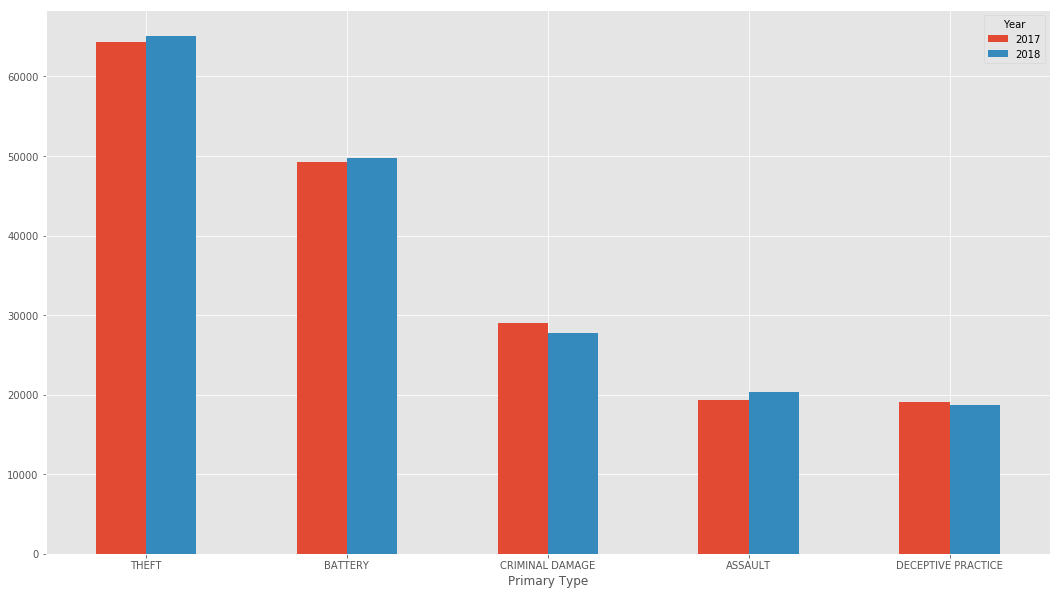

In [6]:
count_ax = type_count_df[:10].Count.unstack().plot.bar(stacked=False, figsize=(18,10), rot=0)
plt.show()

In [7]:
year_df = crime_df.groupby(["Year"]).size().to_frame("Count")
year_df

,Count
Year,
2017,268098
2018,266261


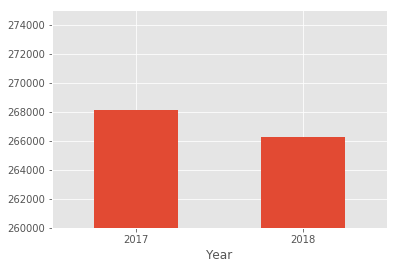

In [8]:
year_ax = year_df.plot(kind="bar", legend=False, rot=0)
year_ax.set_ylim(260000, 275000)
plt.show()

In [39]:
crime_df["Block"].value_counts().count()

30952

In [31]:
crime_df.groupby(["Longitude", "Latitude"]).size().to_frame("Count").sort_values(["Count"], ascending=False)

,,Count
Longitude,Latitude,
-87.627877,41.883500,1006
-87.624097,41.897895,584
-87.905227,41.976290,544
-87.639235,41.868542,502
-87.741529,41.754593,468
-87.709271,41.868181,460
-87.634088,41.742710,427
-87.627845,41.882394,416
-87.627760,41.881718,393


In [15]:
c = Census(my_api_key.MY_API_KEY, year=2017)

In [40]:
pov_list = c.acs5.state_county_blockgroup(("NAME"), '17', '031', Census.ALL)
pov_json = json.dumps(pov_list)
pov_df = pd.read_json(pov_json)
pov_df.head(30)

,NAME,block group,county,state,tract
0,"Block Group 1, Census Tract 2519, Cook County,...",1,31,17,251900
1,"Block Group 2, Census Tract 2519, Cook County,...",2,31,17,251900
2,"Block Group 1, Census Tract 8211.01, Cook Coun...",1,31,17,821101
3,"Block Group 3, Census Tract 8211.01, Cook Coun...",3,31,17,821101
4,"Block Group 2, Census Tract 8211.01, Cook Coun...",2,31,17,821101
5,"Block Group 4, Census Tract 8211.01, Cook Coun...",4,31,17,821101
6,"Block Group 1, Census Tract 8202.02, Cook Coun...",1,31,17,820202
7,"Block Group 3, Census Tract 8202.02, Cook Coun...",3,31,17,820202
8,"Block Group 2, Census Tract 8202.02, Cook Coun...",2,31,17,820202
9,"Block Group 4, Census Tract 8203, Cook County,...",4,31,17,820300


In [44]:
tracts = gpd.read_file("data/census_tract.geojson")
tracts.head()

,statefp10,name10,commarea_n,namelsad10,commarea,geoid10,notes,tractce10,countyfp10,geometry
0,17,8424,44,Census Tract 8424,44,17031842400,,842400,031,(POLYGON ((-87.62404799998049 41.7302169999839...
1,17,8403,59,Census Tract 8403,59,17031840300,,840300,031,(POLYGON ((-87.6860799999848 41.82295600001154...
2,17,8411,34,Census Tract 8411,34,17031841100,,841100,031,(POLYGON ((-87.62934700001182 41.8527970000265...
3,17,8412,31,Census Tract 8412,31,17031841200,,841200,031,(POLYGON ((-87.68813499997718 41.8556909999909...
4,17,8390,32,Census Tract 8390,32,17031839000,,839000,031,(POLYGON ((-87.63312200003458 41.8744880000269...


In [59]:
crime_df["Coordinates"] = list(zip(crime_df.Longitude, crime_df.Latitude))

In [60]:
crime_df["Coordinates"] = crime_df["Coordinates"].apply(Point)

In [61]:
crime_gdf = gpd.GeoDataFrame(crime_df, geometry='Coordinates')

In [62]:
crime_gdf.head(20)

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location,Coordinates
0,11094370,JA440032,09/21/2017 12:15:00 AM,072XX N CALIFORNIA AVE,1122,DECEPTIVE PRACTICE,COUNTERFEIT CHECK,CURRENCY EXCHANGE,True,False,...,2.0,10,1156443.0,1947707.0,2017,03/01/2018 03:52:35 PM,42.012293,-87.699714,"(42.012293397, -87.699714109)",POINT (-87.699714109 42.012293397)
1,11118031,JA470589,10/12/2017 07:14:00 PM,055XX W GRAND AVE,1345,CRIMINAL DAMAGE,TO CITY OF CHICAGO PROPERTY,JAIL / LOCK-UP FACILITY,True,False,...,19.0,14,1138788.0,1913480.0,2017,03/01/2018 03:52:35 PM,41.918712,-87.765511,"(41.918711651, -87.76551063)",POINT (-87.76551062999999 41.918711651)
2,11134189,JA491697,10/30/2017 11:52:00 AM,043XX S TALMAN AVE,4651,OTHER OFFENSE,SEX OFFENDER: FAIL REG NEW ADD,APARTMENT,True,False,...,58.0,26,1159425.0,1875711.0,2017,03/01/2018 03:52:35 PM,41.814670,-87.690727,"(41.814669784, -87.690726696)",POINT (-87.690726696 41.814669784)
3,11156462,JA521389,09/29/2017 06:45:00 PM,055XX W BELMONT AVE,1110,DECEPTIVE PRACTICE,BOGUS CHECK,CURRENCY EXCHANGE,True,False,...,19.0,11,1138653.0,1920720.0,2017,03/01/2018 03:52:35 PM,41.938581,-87.765831,"(41.938581442, -87.765830579)",POINT (-87.765830579 41.938581442)
4,11164874,JA531910,12/01/2017 06:20:00 AM,022XX W CHICAGO AVE,0265,CRIM SEXUAL ASSAULT,AGGRAVATED: OTHER,STREET,True,False,...,24.0,02,1161264.0,1905292.0,2017,03/01/2018 03:52:35 PM,41.895805,-87.683159,"(41.895805099, -87.683159355)",POINT (-87.683159355 41.895805099)
5,10974196,JA298243,06/08/2017 04:02:00 PM,001XX E 59TH ST,143A,WEAPONS VIOLATION,UNLAWFUL POSS OF HANDGUN,ALLEY,True,False,...,40.0,15,1178308.0,1865932.0,2017,02/11/2018 03:54:58 PM,41.787427,-87.621759,"(41.78742694, -87.621758727)",POINT (-87.62175872700001 41.78742694)
6,10995008,JA322389,06/25/2017 07:00:00 PM,003XX W 103RD ST,031A,ROBBERY,ARMED: HANDGUN,SMALL RETAIL STORE,True,False,...,49.0,03,1175895.0,1836626.0,2017,02/11/2018 03:54:58 PM,41.707062,-87.631483,"(41.707062135, -87.631482564)",POINT (-87.631482564 41.707062135)
7,11086755,JA430240,09/06/2017 01:30:00 PM,032XX W 26TH ST,0810,THEFT,OVER $500,OTHER,True,False,...,30.0,06,1155313.0,1886555.0,2017,02/11/2018 03:54:58 PM,41.844510,-87.705519,"(41.844510467, -87.705519454)",POINT (-87.705519454 41.844510467)
8,11162428,JA529032,11/28/2017 09:43:00 PM,026XX S CALIFORNIA BLVD,5131,OTHER OFFENSE,VIOLENT OFFENDER: ANNUAL REGISTRATION,JAIL / LOCK-UP FACILITY,True,False,...,30.0,26,1158280.0,1886310.0,2017,02/11/2018 03:54:58 PM,41.843778,-87.694638,"(41.843778126, -87.694637678)",POINT (-87.69463767799999 41.843778126)
9,11175304,JA545986,12/11/2017 07:15:00 PM,007XX N SACRAMENTO BLVD,031A,ROBBERY,ARMED: HANDGUN,SIDEWALK,True,False,...,23.0,03,1156092.0,1904769.0,2017,02/11/2018 03:54:58 PM,41.894476,-87.702169,"(41.894475919, -87.702169158)",POINT (-87.70216915799999 41.894475919)


In [63]:
test = gpd.sjoin(crime_gdf, tracts, how="inner", op='intersects')
test.head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,index_right,statefp10,name10,commarea_n,namelsad10,commarea,geoid10,notes,tractce10,countyfp10
0,11094370,JA440032,09/21/2017 12:15:00 AM,072XX N CALIFORNIA AVE,1122,DECEPTIVE PRACTICE,COUNTERFEIT CHECK,CURRENCY EXCHANGE,True,False,...,366,17,202,2,Census Tract 202,2,17031020200,,020200,031
2813,10816694,JA116697,01/15/2017 07:05:00 AM,024XX W TOUHY AVE,0910,MOTOR VEHICLE THEFT,AUTOMOBILE,NURSING HOME/RETIREMENT HOME,False,False,...,366,17,202,2,Census Tract 202,2,17031020200,,020200,031
3711,10818486,JA118889,01/17/2017 09:41:00 AM,073XX N CAMPBELL AVE,502R,OTHER OFFENSE,VEHICLE TITLE/REG OFFENSE,STREET,False,False,...,366,17,202,2,Census Tract 202,2,17031020200,,020200,031
4239,10819624,JA120126,01/18/2017 01:30:00 AM,030XX W JARVIS AVE,0820,THEFT,$500 AND UNDER,STREET,False,False,...,366,17,202,2,Census Tract 202,2,17031020200,,020200,031
4248,10819643,JA120113,01/17/2017 06:00:00 PM,027XX W TOUHY AVE,0610,BURGLARY,FORCIBLE ENTRY,COMMERCIAL / BUSINESS OFFICE,False,False,...,366,17,202,2,Census Tract 202,2,17031020200,,020200,031
